In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [2]:
colors={'rosa':'#ff66c4','azul':'#5271ff','verde':'#7ED957', 'laranja':'#f6672a'}
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 15
bbox = dict(boxstyle="round", alpha=0.7, color=colors['rosa'])

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
device

device(type='cuda')

In [5]:
device = 'cpu'

In [24]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 2080'

In [25]:
def get_image(path, image_transform, size = (300,300)):
  image = Image.open(path)
  image = image.resize(size = size,resample = Image.LANCZOS)
  image = image_transform(image).unsqueeze(0) #Adds batch dimension
  return image.to(device)

In [26]:
def get_gram(image_matrix):
  """
  Uses the gram matrix to extract image similarities
  """

  _, channels, height, width = image_matrix.size()
  image_matrix = image_matrix.view(channels, height*width) #Flatten the image
  image_matrix = torch.mm(image_matrix,image_matrix.t()) #Product between image and its transpose
  return image_matrix

In [27]:
def denormalize_image(image):
  """
  Denormalizes image and transforms in numpy array
  Mean and Standard deviation values were taken from imagenet documentation

  """

  image = image.numpy().transpose((1,2,0)) #Pytorch uses (channels, height, width), numpy uses (height, width, channels)
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  image = image*std + mean
  image = np.clip(image,0,1)
  return image

In [28]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg = models.vgg16(pretrained = True).features
    self.selected_layers = ['3','8','15','22'] #Layers after ReLU activation

  def forward(self,x):
    layer_features = []
    for layer_number, layer in self.vgg._modules.items():
      x = layer(x)
      if layer_number in self.selected_layers:
        layer_features.append(x)
    return layer_features


In [29]:
#mean and std from Imagenet
image_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(
                                      mean=(0.485,0.456,0.406),
                                      std=(0.229,0.224,0.225))
                                      ])
path_original = './datasets/dog.jpg'
path_style = './datasets/style_v4.jpg'

original_image = get_image(path_original, image_transform)
style_image = get_image(path_style, image_transform)
generated_image = original_image.clone()
generated_image.requires_grad = True
optimizer = torch.optim.Adam([generated_image], lr = 0.003, betas= [0.5,0.999])
encoder = Model().to(device)

for parameter in encoder.parameters():
    parameter.requires_grad = False
#encoder.eval() #Freezes the parameters

C:\Users\roger\Documents\pytorch_venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\roger\Documents\pytorch_venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
run_time = []

for i in range(1):

  epochs = 8500
  original_weight = 1
  style_weight = 500

  #Resetting image and model
  original_image = get_image(path_original, image_transform)
  style_image = get_image(path_style, image_transform)
  generated_image = original_image.clone()
  generated_image.requires_grad = True
  optimizer = torch.optim.Adam([generated_image], lr = 0.003, betas= [0.5,0.999])
  encoder = Model().to(device)
  for parameter in encoder.parameters():
    parameter.requires_grad = False

  time1 = time()
  for epoch in range(epochs):
    original_features = encoder.forward(original_image)
    style_features = encoder.forward(style_image)
    generated_features = encoder.forward(generated_image)

    original_loss = torch.mean((original_features[-1] - generated_features[-1])**2) #MSE
    style_loss = 0

    for gen_features, stl_features in zip(generated_features, style_features):
      _, channels, height, width = gen_features.size()
      gram_gen_features = get_gram(gen_features)
      gram_stl_features = get_gram(stl_features)

      style_loss += torch.mean((gram_gen_features - gram_stl_features)**2)/(channels*height*width) #Normalized MSE

    loss = original_weight*original_loss + style_weight*style_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) %10 == 0:
      print(f'Epoch [{epoch+1}], Loss [Original/Style]: [{original_loss.item():.2f} / {style_loss.item():.2f}], Total loss: {loss.item():.2f}')
  time2 = time()
  run_time.append(time2-time1)
  print(f'Tempo: {(run_time[-1]):.3f} s')

Epoch [10], Loss [Original/Style]: [1.07 / 8552.49], Total loss: 4276246.50
Epoch [20], Loss [Original/Style]: [2.44 / 7732.09], Total loss: 3866049.50
Epoch [30], Loss [Original/Style]: [3.26 / 6879.71], Total loss: 3439857.50
Epoch [40], Loss [Original/Style]: [3.71 / 6088.50], Total loss: 3044253.00
Epoch [50], Loss [Original/Style]: [3.98 / 5423.85], Total loss: 2711930.25
Epoch [60], Loss [Original/Style]: [4.18 / 4876.83], Total loss: 2438419.75
Epoch [70], Loss [Original/Style]: [4.33 / 4423.72], Total loss: 2211865.00
Epoch [80], Loss [Original/Style]: [4.45 / 4045.25], Total loss: 2022630.00
Epoch [90], Loss [Original/Style]: [4.54 / 3724.10], Total loss: 1862055.12
Epoch [100], Loss [Original/Style]: [4.61 / 3450.23], Total loss: 1725119.00
Epoch [110], Loss [Original/Style]: [4.66 / 3214.22], Total loss: 1607114.12
Epoch [120], Loss [Original/Style]: [4.71 / 3008.98], Total loss: 1504493.12
Epoch [130], Loss [Original/Style]: [4.75 / 2828.51], Total loss: 1414259.50
Epoch [1

In [39]:
generated_image = generated_image.detach().cpu().squeeze()
generated_image = denormalize_image(generated_image)

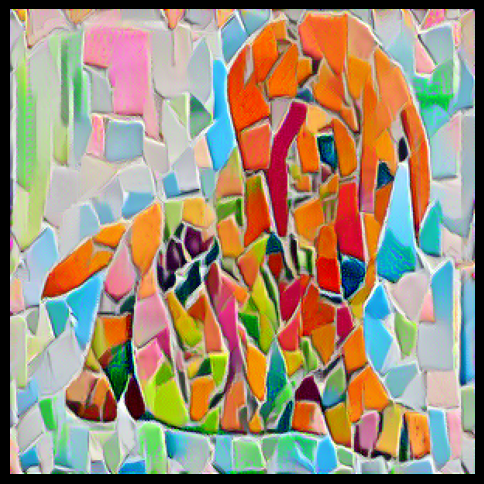

In [40]:
plt.figure(figsize=(6,10))
plt.imshow(generated_image)
plt.axis('off')
plt.show()

In [41]:
run_time = np.array(run_time)

In [35]:
np.round(np.mean(run_time),3)

3.295

In [51]:
375/3.2*280/60/60

9.114583333333334

Text(0, 0.5, 'Tempo')

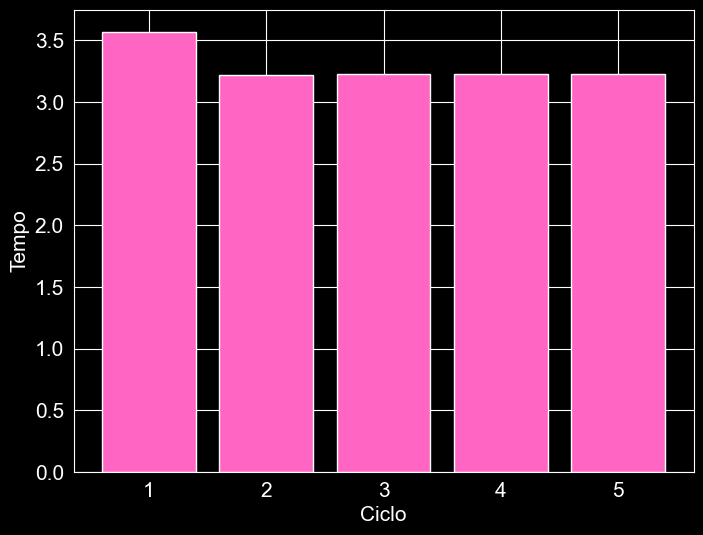

In [37]:
plt.bar(np.array([*range(1,6)]),np.round(run_time,3), color = colors['rosa'])
plt.xlabel('Ciclo')
plt.ylabel('Tempo')